In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

import numpy as np
import torch.utils.data as data


class PalindromeDataset(data.Dataset):

    def __init__(self, input_length, total_len, one_hot=False):
        """
        Args:
            seq_length: length of the sequence(both input and target)
            total_len: total number of samples in the dataset
            one_hot: whether to use one-hot encoding or not
        """
        self.input_length = input_length
        self.seq_length = input_length+1
        self.one_hot = one_hot
        self.half_length = math.ceil(self.seq_length/2)
        max_num = 10 ** self.half_length
        self.total_len = total_len
        if self.total_len > max_num:
            # print("Warning: total_len is larger than the maximum possible length. ")
            # print("Setting total_len to the maximum possible length. ")
            # print(
            #     "Warning: access length of dataset by len(dataset) to get the actual length. ")
            self.total_len = 10 ** self.half_length
        self.data = np.random.default_rng().choice(
            max_num, self.total_len, replace=False)
        self.mapping = np.eye(10) if one_hot else np.arange(10).reshape(10, 1)

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        # Keep last digit as target label.
        full_palindrome = self.generate_palindrome(self.data[idx])
        # Split palindrome into inputs (N-1 digits) and target (1 digit)
        inputs, labels = full_palindrome[0:-1], int(full_palindrome[-1])
        inputs = self.mapping[inputs].astype(np.float32)
        return inputs, labels

    def generate_palindrome(self, data):
        data = tuple(map(int, str(data)))
        left = np.zeros(self.half_length).astype(np.uint64)
        left[-len(data):] = data
        if self.seq_length % 2 == 0:
            right = left[::-1]
        else:
            right = left[-2::-1]
        return np.concatenate((left, right))


In [2]:
import torch


class AverageMeter(object):
    def __init__(self, name, fmt=":f"):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = "{name}: {val" + self.fmt + "} ({avg" + self.fmt + "})"
        return fmtstr.format(**self.__dict__)


@torch.no_grad()
def accuracy(output, target):
    # Implementation here ...
    predicted = torch.argmax(output, dim=1)
    correct = (predicted == target).sum().item()
    accuracy = correct / target.size(0)
    
    return accuracy


In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torch.nn as nn


class VanillaRNN(nn.Module):

    def __init__(self, input_length, input_dim, hidden_dim, output_dim):
        super(VanillaRNN, self).__init__()
        # Initialization here ...
        self.input_length = input_length    
        self.hidden_dim = hidden_dim
        self.Whx = nn.Linear(input_dim, hidden_dim, bias=False)
        self.Whh = nn.Linear(hidden_dim, hidden_dim, bias=True)

        self.bh = nn.Parameter(torch.zeros(hidden_dim))
        self.Wph = nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        # Implementation here ...
        ## print(f"forward been activated!")
        batch_size, input_length, _ = x.size()

        # initialization
        h = torch.zeros(batch_size, self.hidden_dim, device=x.device)
        
        for t in range(input_length):
            x_t = x[:, t, :]
            h = torch.tanh(self.Whx(x_t) + self.Whh(h) + self.bh)

        # activation
        o = self.Wph(h)
        y_hat = torch.softmax(o, dim=1)

        return y_hat

    # add more methods here if needed


1
device is cuda:2
Here is a test for 3
Final Validation Accuracy for input length 3: 0.5000
Here is a test for 4
Final Validation Accuracy for input length 4: 1.0000
Here is a test for 5
Final Validation Accuracy for input length 5: 1.0000
Here is a test for 6
Early stopping triggered at epoch 195
Final Validation Accuracy for input length 6: 1.0000
Here is a test for 7
Early stopping triggered at epoch 151
Final Validation Accuracy for input length 7: 0.8125
Here is a test for 8
Final Validation Accuracy for input length 8: 0.8925
Here is a test for 9
Final Validation Accuracy for input length 9: 0.7075


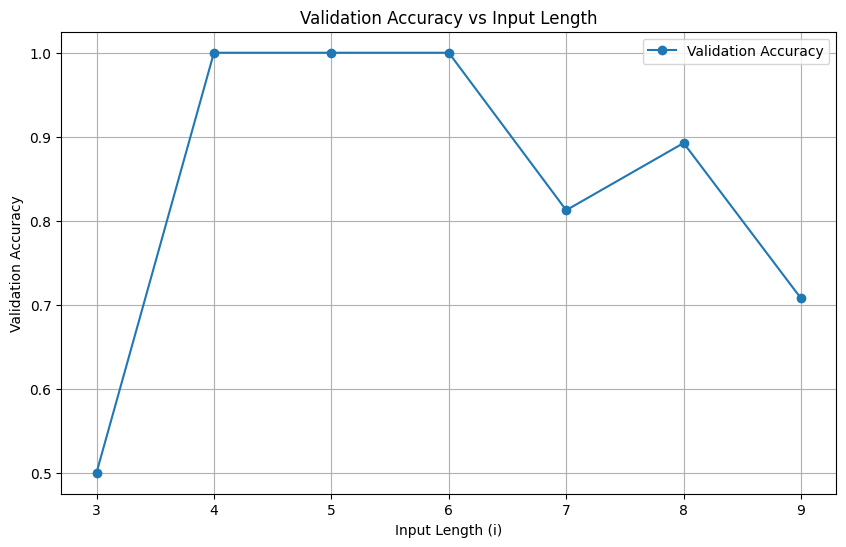

Plot saved as accuracy_loss_plot_RNN.png
Done training.


<Figure size 640x480 with 0 Axes>

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse

import torch
import torch.utils
from torch.utils.data import DataLoader
import torch.utils.data
import torch.nn as nn
import matplotlib.pyplot as plt

from dataset import PalindromeDataset
from vanilla_rnn import VanillaRNN
from utils import AverageMeter, accuracy

class Config:
    def __init__(self):
        # Model parameters
        self.input_length = 100  # Default value of LENGTH_DEFAULT
        self.input_dim = 1
        self.num_classes = 10
        self.num_hidden = 64
        self.batch_size = 32
        self.learning_rate = 0.005
        self.max_epoch = 300
        self.max_norm = 10.0
        self.data_size = 10000
        self.portion_train = 0.8


LENGTH_DEFAULT = 5

def train(model, data_loader, optimizer, criterion, device, config):
    # TODO set model to train mode
    model.train()
    losses = AverageMeter("Loss")
    accuracies = AverageMeter("Accuracy")
    for step, (batch_inputs, batch_targets) in enumerate(data_loader):
        # Add more code here ...
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        acc = accuracy(outputs, batch_targets)

        optimizer.zero_grad()
        loss.backward()

        # the following line is to deal with exploding gradients
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.max_norm)
        optimizer.step()
        losses.update(loss.item(), batch_inputs.size(0))
        accuracies.update(acc, batch_inputs.size(0))
        # Add more code here ...
        # if step % 10 == 0:
        # print(f"[{step}/{len(data_loader)}]", losses, accuracies)
    return losses.avg, accuracies.avg


@torch.no_grad()
def evaluate(model, data_loader, criterion, device, config):
    # TODO set model to evaluation
    model.eval()
    losses = AverageMeter("Loss")
    accuracies = AverageMeter("Accuracy")
    for step, (batch_inputs, batch_targets) in enumerate(data_loader):
        # Add more code here ...

        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        acc = accuracy(outputs, batch_targets)

        losses.update(loss.item(), batch_inputs.size(0))
        accuracies.update(acc, batch_inputs.size(0))

        # if step % 10 == 0:
        # print(f"[{step}/{len(data_loader)}]", losses, accuracies)
    return losses.avg, accuracies.avg


def main(config):
    device = "cuda:2" if torch.cuda.is_available() else "cpu"
    print(f"device is {device}")
    # print(config)
    
    accuracies = []
    
    for i in range(3, 12):
        
        # 初始化一个变量用来保存最好的验证损失
        best_val_loss = float('inf')
        # 记录连续未改善的次数
        patience_counter = 0
        # 设置一个早停的容忍度
        patience = 100  # 例如：5次
        
        print(f"Here is a test for {i}")
        
        # Initialize the model that we are going to use
        model = VanillaRNN(
            input_length=config.input_length,
            input_dim=config.input_dim,
            hidden_dim=config.num_hidden,
            output_dim=config.num_classes,
        )  # fixme
        model.to(device)

        # Initialize the dataset and data loader
        dataset = PalindromeDataset(
            input_length=i, total_len=config.data_size
        )  # fixme
        inputs, label = dataset[0]
        # print("Input:", inputs)
        # print("Label:", label)
        # Split dataset into train and validation sets
        train_size = int(config.portion_train * len(dataset))
        test_size = int(len(dataset) - train_size)

        # print(f"train_size:{train_size}")
        # print(f"test_size:{test_size}")
        train_dataset, val_dataset = torch.utils.data.random_split(
            dataset, [train_size, test_size]
        )  # fixme
        # Create data loaders for training and validation
        train_dloader = DataLoader(
            train_dataset, batch_size=config.batch_size, shuffle=True
        )  # fixme

        data_iter = iter(train_dloader)  # 创建一个迭代器
        inputs, labels = next(data_iter)  # 获取一个批次的数据和标签

        # 查看输入和标签的形状
        # print(f"Inputs shape: {inputs.shape}")  # 查看输入数据的形状
        # print(f"Labels shape: {labels.shape}")  # 查看标签数据的形状

        val_dloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=True)

        # Setup the loss and optimizer
        criterion = nn.CrossEntropyLoss()  # fixme
        optimizer = torch.optim.RMSprop(
            model.parameters(), lr=config.learning_rate, alpha=0.99  # 学习率
        )
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer=optimizer, step_size=100, gamma=0.1
        )  # fixme
        
        # val_losses = []
        # val_acces = []

        for epoch in range(config.max_epoch):
            # print(f"Epoch [{epoch+1}/{config.max_epoch}]")
            # Train the model for one epoch
            train_loss, train_acc = train(
                model, train_dloader, optimizer, criterion, device, config
            )

            # Evaluate the trained model on the validation set
            val_loss, val_acc = evaluate(model, val_dloader, criterion, device, config)
            scheduler.step()
            # val_losses.append(val_loss)
            # val_acces.append(val_acc)
            
            # print(
            #     f"Epoch [{epoch+1}/{config.max_epoch}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            #     f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
            # )
            
            # 检查是否需要早停
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0  # 重置早停计数器
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch + 1}")
                    break
                
        print(f"Final Validation Accuracy for input length {i}: {val_acc:.4f}")
        accuracies.append((i, val_acc))
    
    # 绘制图表
    x = [item[0] for item in accuracies]
    y = [item[1] for item in accuracies]

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', label='Validation Accuracy')
    plt.title('Validation Accuracy vs Input Length')
    plt.xlabel('Input Length (i)')
    plt.ylabel('Validation Accuracy')
    plt.grid()
    plt.legend()
    plt.show()
    plt.savefig('accuracy_loss_plot_RNN_length.png')
    print("Plot saved as accuracy_loss_plot_RNN.png")
    
    # # Plot accuracy and loss
    # plt.figure(figsize=(10, 5))

    # # Plot training and test accuracy
    # plt.subplot(1, 2, 1)
    # # plt.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy')
    # plt.plot(range(len(val_acces)), val_acces, label='Test Accuracy')
    # plt.xlabel('Evaluation Epoch')
    # plt.ylabel('Accuracy')
    # plt.title('Test Accuracy')
    # plt.legend()
    
    #  # Plot loss
    # plt.subplot(1, 2, 2)
    # plt.plot(range(len(val_losses)), val_losses, label='Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training Loss')
    # plt.legend()

    # # Save the plot
    # plt.tight_layout()
    # plt.savefig('accuracy_loss_plot_RNN.png')  # Save to local file
    # print("Plot saved as accuracy_loss_plot_RNN.png")
        
    # print(f"Final Validation Accuracy for input length {5}: {val_acc:.4f}")

    print("Done training.")


if __name__ == "__main__":

    # Parse training configuration
    parser = argparse.ArgumentParser()
    print("1")

    # # Model params
    # parser.add_argument(
    #     "--input_length", type=int, default=LENGTH_DEFAULT, help="Length of an input sequence"
    # )
    # parser.add_argument(
    #     "--input_dim", type=int, default=1, help="Dimensionality of input sequence"
    # )
    # parser.add_argument(
    #     "--num_classes", type=int, default=10, help="Dimensionality of output sequence"
    # )
    # parser.add_argument(
    #     "--num_hidden",
    #     type=int,
    #     default=64,
    #     help="Number of hidden units in the model",
    # )
    # parser.add_argument(
    #     "--batch_size",
    #     type=int,
    #     default=32,
    #     help="Number of examples to process in a batch",
    # )
    # parser.add_argument(
    #     "--learning_rate", type=float, default=0.005, help="Learning rate"
    # )
    # parser.add_argument(
    #     "--max_epoch", type=int, default=300, help="Number of epochs to run for"
    # )
    # parser.add_argument("--max_norm", type=float, default=10.0)
    # parser.add_argument(
    #     "--data_size", type=int, default=10000, help="Size of the total dataset"
    # )
    # parser.add_argument(
    #     "--portion_train",
    #     type=float,
    #     default=0.8,
    #     help="Portion of the total dataset used for training",
    # )

    # config = parser.parse_args()
    # print(f"config:{config}")
    # Train the model
    
    config = Config()
    
    main(config)
